# Using TensorFlow for Deep Dream
---------------------------------------

From: Alexander Mordvintsev
https://github.com/tensorflow/tensorflow/tree/master/tensorflow/examples/tutorials/deepdream

Make sure to download the deep dream model here:
   https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip

Run:
```
me@computer:~$ wget https://storage.googleapis.com/download.tensorflow.org/models/inception5h.zip 
me@computer:~$ unzip inception5h.zip
```

> Note: While this code is from the official TensorFlow tutorials (site above), it has been converted to Python 3 and explained line-by-line here.


We start with loading the necessary libraries.

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import matplotlib.pyplot as plt
import numpy as np
import PIL.Image
import tensorflow as tf
from io import BytesIO
from tensorflow.python.framework import ops
ops.reset_default_graph()

%matplotlib inline

Start a computational graph session and set the working directory.

In [2]:
# Start a graph session
graph = tf.Graph()
sess = tf.InteractiveSession(graph=graph)

os.chdir('/home/yanjun/projects/model/')

# Model filename
model_fn = 'tensorflow_inception_graph.pb'

Load the model parameters

In [3]:
# Load graph parameters
with tf.gfile.FastGFile(model_fn, 'rb') as f:
    graph_def = tf.GraphDef()
    graph_def.ParseFromString(f.read())

W0627 11:02:51.235723 140349465646912 deprecation.py:323] From <ipython-input-3-d2e0d7297198>:2: FastGFile.__init__ (from tensorflow.python.platform.gfile) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.gfile.GFile.


Create placeholder for input

In [4]:
t_input = tf.placeholder(np.float32, name='input')

We subtract the mean/bias off of the input image.

In [5]:
# Imagenet average bias to subtract off images
imagenet_mean = 117.0
t_preprocessed = tf.expand_dims(t_input-imagenet_mean, 0)
tf.import_graph_def(graph_def, {'input':t_preprocessed})

Create a list of layers that we can refer to later

In [6]:
layers = [op.name for op in graph.get_operations() if
          op.type=='Conv2D' and 'import/' in op.name]
print(layers[:5])

['import/conv2d0_pre_relu/conv', 'import/conv2d1_pre_relu/conv', 'import/conv2d2_pre_relu/conv', 'import/mixed3a_1x1_pre_relu/conv', 'import/mixed3a_3x3_bottleneck_pre_relu/conv']


Count how many outputs for each layer

In [7]:
feature_nums = [int(graph.get_tensor_by_name(name+':0').get_shape()[-1]) for
                name in layers]
# Print count of layers and outputs (features nodes)
print('Number of layers', len(layers))
print('Total number of feature channels:', sum(feature_nums))

Number of layers 59
Total number of feature channels: 7548


Picking some internal layer. Note that we use outputs before applying the ReLU nonlinearity to have non-zero gradients for features with negative initial activations.

### Note: to get different deep-dream styles, change the layer name or the channel number below!

In [8]:
layer = 'mixed4d_3x3_bottleneck_pre_relu'
channel = 30 # picking some feature channel to visualize

We start with a gray image with a little noise.

In [9]:
img_noise = np.random.uniform(size=(224,224,3)) + 100.0

Let's create a function that will plot an image for us to see.

In [10]:
def showarray(a, fmt='jpeg'):
    # First make sure everything is between 0 and 255
    a = np.uint8(np.clip(a, 0, 1)*255)
    # Pick an in-memory format for image display
    f = BytesIO()
    # Create the in memory image
    PIL.Image.fromarray(a).save(f, fmt)
    # Show image
    plt.imshow(a)

Let's also create a helper function for getting a tensor by name.

In [11]:
def T(layer):
    '''Helper for getting layer output tensor'''
    return graph.get_tensor_by_name("import/%s:0"%layer)

The following function returns a function wrapper that will create the placeholder inputs of a specified dtype

In [12]:
def tffunc(*argtypes):
    '''Helper that transforms TF-graph generating function into a
    regular one.
    See "resize" function below.
    '''
    placeholders = list(map(tf.placeholder, argtypes))
    def wrap(f):
        out = f(*placeholders)
        def wrapper(*args, **kw):
            return out.eval(dict(zip(placeholders, args)),
                            session=kw.get('session'))
        return wrapper
    return wrap

Helper function that uses TF to resize an image

In [13]:
def resize(img, size):
    img = tf.expand_dims(img, 0)
    # Change 'img' size by linear interpolation
    return tf.image.resize_bilinear(img, size)[0, :, :, :]

Since we calculate the gradient (updates to image) in a tiled fashion, we will end up with tiled like effects in the image.

To prevent this, we will use `np.roll()` function to shift our image randomly (slightly) to prevent this.

In [14]:
def calc_grad_tiled(img, t_grad, tile_size=512):
    '''Compute the value of tensor t_grad over the image in a tiled way.
    Random shifts are applied to the image to blur tile boundaries over 
    multiple iterations.'''
    # Pick a subregion square size
    sz = tile_size
    # Get the image height and width
    h, w = img.shape[:2]
    # Get a random shift amount in the x and y direction
    sx, sy = np.random.randint(sz, size=2)
    # Randomly shift the image (roll image) in the x and y directions
    img_shift = np.roll(np.roll(img, sx, 1), sy, 0)
    # Initialize the while image gradient as zeros
    grad = np.zeros_like(img)
    # Now we loop through all the sub-tiles in the image
    for y in range(0, max(h-sz//2, sz),sz):
        for x in range(0, max(w-sz//2, sz),sz):
            # Select the sub image tile
            sub = img_shift[y:y+sz,x:x+sz]
            # Calculate the gradient for the tile
            g = sess.run(t_grad, {t_input:sub})
            # Apply the gradient of the tile to the whole image gradient
            grad[y:y+sz,x:x+sz] = g
    # Return the gradient, undoing the roll operation
    return np.roll(np.roll(grad, -sx, 1), -sy, 0)

We start the deep-dream process. Read the in-line comments below.

In [15]:
def render_deepdream(t_obj,
                     img0=img_noise,
                     iter_n=10,
                     step=1.5,
                     octave_n=4,
                     octave_scale=1.4):
    # defining the optimization objective, the objective is the mean
    # of the feature
    t_score = tf.reduce_mean(t_obj)
    # Our gradients will be defined as changing the t_input
    # to get closer to the values of t_score.
    # Here, t_score is the mean of the feature we select,
    # and t_input will be the image octave (starting with the last)
    t_grad = tf.gradients(t_score, t_input)[0] # behold the power of automatic differentiation!

    # Store the image
    img = img0
    # Initialize the octave list
    octaves = []
    # Since we stored the image, we need to only calculate n-1 octaves
    for i in range(octave_n-1):
        # Extract the image shape
        hw = img.shape[:2]
        # Resize the image, scale by the octave_scale (resize by linear interpolation)
        lo = resize(img, np.int32(np.float32(hw)/octave_scale))
        # Residual is hi.  Where...
        # residual = image - (Resize lo to be hw-shape)
        hi = img-resize(lo, hw)
        # Save the lo image for re-iterating
        img = lo
        # Save the extracted hi-image
        octaves.append(hi)
    
    # generate details octave by octave
    for octave in range(octave_n):
        if octave>0:
            # Start with the last octave
            hi = octaves[-octave]
            #
            img = resize(img, hi.shape[:2])+hi
        for i in range(iter_n):
            # Calculate gradient of the image.
            g = calc_grad_tiled(img, t_grad)
            # Ideally, we would just add the gradient, g, but
            # we want do a forward step size of it ('step'),
            # and divide it by the avg. norm of the gradient, so
            # we are adding a gradient of a certain size each step.
            # Also, to make sure we aren't dividing by zero,
            # we add 1e-7.
            img += g*(step / (np.abs(g).mean()+1e-7))
            print('.',end = ' ')
        showarray(img/255.0)

Run Deep Dream

. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

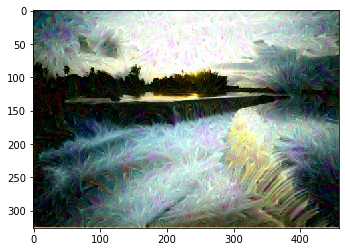

In [16]:
# Create resize function that has a wrapper that
# creates specified placeholder types
resize = tffunc(np.float32, np.int32)(resize)

# Open image
img0 = PIL.Image.open('/home/yanjun/projects/tensorflow_cookbook/08_Convolutional_Neural_Networks/06_Deepdream/book_cover.jpg')
img0 = np.float32(img0)
# Show Original Image
showarray(img0/255.0)

# Create deep dream
render_deepdream(T(layer)[:,:,:,channel], img0, iter_n=15)

sess.close()